## Dataset Preprocessing 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import preprocessing, linear_model, svm, ensemble
from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV)
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn_pandas import DataFrameMapper
from utilities import *
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

train_og = pd.read_csv('train.csv')
train_og = train_og.set_index('Id')
train_og = train_og.copy()
test_X_og = pd.read_csv('test.csv')
test_X_og = test_X_og.set_index('Id')
test_X_og = test_X_og.copy()

train_og = train_og.fillna(0)
test_X_og = test_X_og.fillna(0)

numerical, categorical = columns()
train_og[categorical] = train_og[categorical].astype('str')
train_og[numerical] = train_og[numerical].astype('float')
test_X_og[categorical] = test_X_og[categorical].astype('str')
test_X_og[numerical] = test_X_og[numerical].astype('float')

train_X_og, train_Y_og = train_og[train_og.columns[:-1]], train_og[train_og.columns[-1]]

X_og = pd.concat([train_X_og, test_X_og])

## Y value preprocessing

mean = 180921.1959
std = 79415.2919
skewness = 1.8829
kurtosis = 6.5363
mean = 12.0241
std = 0.3993
skewness = 0.1212
kurtosis = 0.8026


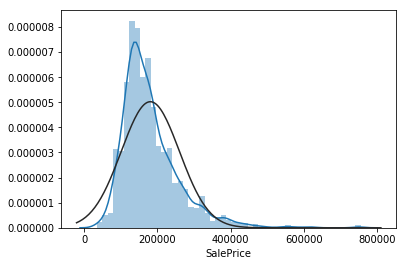

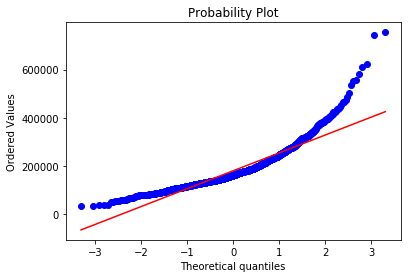

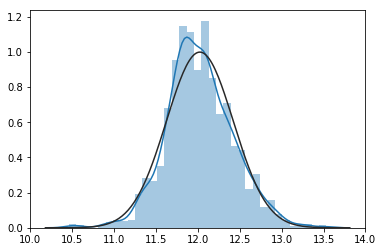

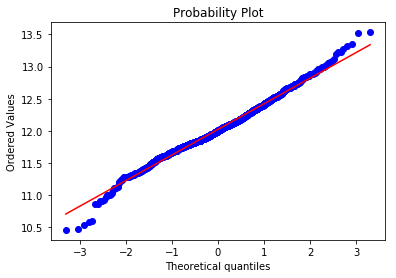

In [2]:
plt.figure()
sns.distplot(train_Y_og, fit=stats.norm);
mean, std = stats.norm.fit(train_Y_og)
print('mean = {:.4f}\nstd = {:.4f}\nskewness = {:.4f}\nkurtosis = {:.4f}'
      .format(mean, std, train_Y_og.skew(), train_Y_og.kurtosis()))
plt.figure()
stats.probplot(train_Y_og, plot=plt);

train_Y = np.log1p(train_Y_og).to_numpy()

plt.figure()
sns.distplot(train_Y, fit=stats.norm);
mean, std = stats.norm.fit(train_Y)
print('mean = {:.4f}\nstd = {:.4f}\nskewness = {:.4f}\nkurtosis = {:.4f}'
      .format(mean, std, stats.skew(train_Y), stats.kurtosis(train_Y)))
plt.figure()
stats.probplot(train_Y, plot=plt);

## Feature Classification

In [3]:
feature_class = pd.read_csv('feature_class.csv', names=['feature', 'class', 'note'])

feature_class['feature'] = feature_class['feature'].str.strip()
feature_class['class'] = feature_class['class'].str.strip()
feature_class['note'] = feature_class['note'].str.strip()

numerical = []
nominal = []
ordinal = []
for i in X_og.columns:
    if feature_class['class'][feature_class['feature']==i].values == 'Numerical':
        numerical.append(i)
    elif feature_class['class'][feature_class['feature']==i].values == 'Nominal':
        nominal.append(i)
    elif feature_class['class'][feature_class['feature']==i].values == 'Ordinal':
        ordinal.append(i)

## Numerical feature skewness

In [4]:
skewness = X_og[numerical].skew().sort_values(ascending=False)

X_og[numerical] = np.log1p(X_og[numerical])

## X value transformation

In [5]:
mapper = DataFrameMapper([
    (numerical, preprocessing.PowerTransformer()),
    (nominal, preprocessing.OneHotEncoder(sparse=False)), 
    (ordinal, preprocessing.OrdinalEncoder())],
    df_out=True)

X = mapper.fit_transform(X_og)

train_X = X.loc[train_X_og.index].to_numpy()
test_X = X.loc[test_X_og.index].to_numpy()

train_X, dev_X, train_Y, dev_Y = train_test_split(train_X, train_Y, random_state=42)

## Valuation Metric

In [6]:
def rmsle_non_logged(y_true, y_pred):
    import numpy as np
    from sklearn.metrics import mean_squared_error, make_scorer
    rmsle = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmsle

def rmsle_logged(y, y0):
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))

rmsle_scorer = make_scorer(rmsle_logged, greater_is_better=False)

## model 01

In [7]:
model1 = linear_model.Ridge()
grid1 = {'alpha' : [0.5, 1, 3]}

In [8]:
model1, train_score1, dev_score1 = gridsearchcv(model1, grid1, train_X, train_Y, dev_X, dev_Y)

y1 = np.expm1(model1.predict(test_X))

grid search best parameters: {'alpha': 3}
grid search best scores: -0.0112
cv score: -0.0112
dev score: 0.0106


## model 02

In [9]:
model2 = linear_model.Lasso()
grid2 = {'alpha' : [0.0005, 0.001, 0.005]}

In [10]:
model2, train_score2, dev_score2 = gridsearchcv(model2, grid2, train_X, train_Y, dev_X, dev_Y)

y2 = np.expm1(model2.predict(test_X))

grid search best parameters: {'alpha': 0.001}
grid search best scores: -0.0108
cv score: -0.0108
dev score: 0.0106


## model 03

In [11]:
model3 = linear_model.ElasticNet(max_iter=100)
grid3 = {'alpha' : [0.01, 0.02, 0.03], 
         'l1_ratio' : [0.1, 0.2, 0.3]}

In [12]:
model3, train_score3, dev_score3 = gridsearchcv(model3, grid3, train_X, train_Y, dev_X, dev_Y)

y3 = np.expm1(model3.predict(test_X))

grid search best parameters: {'alpha': 0.01, 'l1_ratio': 0.1}
grid search best scores: -0.0106
cv score: -0.0109
dev score: 0.0107


## model 04

In [13]:
model4 = linear_model.LassoLars()
grid4 = {'alpha' : [0.0001, 0.0005, 0.0009]}

In [14]:
model4, train_score4, dev_score4 = gridsearchcv(model4, grid4, train_X, train_Y, dev_X, dev_Y)

y4 = np.expm1(model4.predict(test_X))

grid search best parameters: {'alpha': 0.0001}
grid search best scores: -0.0108
cv score: -0.0110
dev score: 0.0100


## model 05

In [15]:
model5 = linear_model.BayesianRidge()
grid5 = {'alpha_1' : [1e-06, 2e-06, 3e-06], 
         'alpha_2' : [1e-06, 2e-06, 3e-06], 
         'lambda_1' : [1e-06, 2e-06, 3e-06], 
         'lambda_2' : [1e-06, 2e-06, 3e-06]}

In [16]:
model5, train_score5, dev_score5 = gridsearchcv(model5, grid5, train_X, train_Y, dev_X, dev_Y)

y5 = np.expm1(model5.predict(test_X))

grid search best parameters: {'alpha_1': 1e-06, 'alpha_2': 3e-06, 'lambda_1': 3e-06, 'lambda_2': 1e-06}
grid search best scores: -0.0108
cv score: -0.0108
dev score: 0.0104


## model 06

In [17]:
model6 = XGBRegressor(n_estimators=100)
grid6 = {'max_depth' : [3, 4, 5], 
         'learning_rate' : [0.001, 0.01, 0.1]}

In [18]:
model6, train_score, dev_score = gridsearchcv(model6, grid6, train_X, train_Y, dev_X, dev_Y)

y6 = model6.predict(test_X)

grid search best parameters: {'learning_rate': 0.1, 'max_depth': 4}
grid search best scores: -0.0106
cv score: -0.0107
dev score: 0.0109


## model 07

In [19]:
model7 = svm.SVR()
grid7 = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 
         'degree' : [1, 2], 
         'gamma' : [0.0001, 0.001, 0.002], 
         'C' : [2, 3, 4]}

In [20]:
model7, train_score, dev_score = gridsearchcv(model7, grid7, train_X, train_Y, dev_X, dev_Y)

y7 = model7.predict(test_X)

grid search best parameters: {'C': 4, 'degree': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
grid search best scores: -0.0106
cv score: -0.0110
dev score: 0.0107


## model 08

In [21]:
model8 = ensemble.BaggingRegressor()
grid8 = {'n_estimators' : [40, 45, 50], 
          'max_features' : [40, 45, 50]}

In [22]:
model8, train_score, dev_score = gridsearchcv(model8, grid8, train_X, train_Y, dev_X, dev_Y)

y8 = model8.predict(test_X)

grid search best parameters: {'max_features': 50, 'n_estimators': 40}
grid search best scores: -0.0144
cv score: -0.0146
dev score: 0.0151


## model 09

In [23]:
model9 = ensemble.RandomForestRegressor()
grid9 = {'n_estimators' : [45, 50, 55], 
          'criterion' : ['mse', 'friedman_mse'], 
          'max_depth' : [5, 10, 15], 
          'max_features' : [45, 50, 55]}

In [24]:
model9, train_score, dev_score = gridsearchcv(model9, grid9, train_X, train_Y, dev_X, dev_Y)

y9 = model9.predict(test_X)

grid search best parameters: {'criterion': 'friedman_mse', 'max_depth': 15, 'max_features': 55, 'n_estimators': 55}
grid search best scores: -0.0116
cv score: -0.0119
dev score: 0.0116


## model 10

In [25]:
model10 = ensemble.GradientBoostingRegressor(n_iter_no_change=5)
grid10 = {'loss' : ['ls', 'lad', 'huber', 'quantile'], 
          'learning_rate' : [0.0001, 0.001, 0.1], 
          'n_estimators' : [50, 100, 200], 
          'criterion' : ['mse', 'friedman_mse'], 
          'max_depth' : [2, 4, 6]}

In [26]:
model10, train_score, dev_score = gridsearchcv(model10, grid10, train_X, train_Y, dev_X, dev_Y)

y10 = model10.predict(test_X)

grid search best parameters: {'criterion': 'mse', 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 4, 'n_estimators': 100}
grid search best scores: -0.0110
cv score: -0.0113
dev score: 0.0106


## Predict & Submit

In [27]:
y = (y1 + y2 + y3 + y4 + y5 + y6 + y7 + y8 + y9 + y10)/10

In [28]:
submit = pd.DataFrame(data=[test_X_og.index.values, y]).T
submit.columns = ['Id', 'SalePrice']
submit = submit.astype('int32')
submit.to_csv('submit.csv', index=False)